In [7]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
%matplotlib inline

In [8]:
CH4_DATA=xr.open_dataset("200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc", engine="netcdf4")
CH4_DATA

<xarray.Dataset>
Dimensions:                  (time: 210, bnds: 2, lat: 36, lon: 72, pressure: 10)
Coordinates:
  * time                     (time) datetime64[ns] 2003-01-16T12:00:00 ... 20...
  * lat                      (lat) float64 -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * lon                      (lon) float64 -177.5 -172.5 -167.5 ... 172.5 177.5
Dimensions without coordinates: bnds, pressure
Data variables:
    time_bnds                (time, bnds) datetime64[ns] ...
    lat_bnds                 (lat, bnds) float64 ...
    lon_bnds                 (lon, bnds) float64 ...
    pre                      (pressure) float64 ...
    pre_bnds                 (pressure, bnds) float64 ...
    land_fraction            (lat, lon) float64 ...
    xch4                     (time, lat, lon) float32 ...
    xch4_nobs                (time, lat, lon) float64 ...
    xch4_stderr              (time, lat, lon) float32 ...
    xch4_stddev              (time, lat, lon) float32 ...
    column_averaging_kernel  (time, pressure, lat, lon) float32 ...
    vmr_profile_ch4_apriori  (time, pressure, lat, lon) float32 ...
Attributes: (12/28)
    activity_id:            obs4MIPs
    comment:                Since long time, climate modellers use ensemble a...
    contact:                Maximilian Reuter (maximilian.reuter@iup.physik.u...
    Conventions:            CF-1.7 ODS-2.1
    creation_date:          2021-02-05T09:48:47Z
    data_specs_version:     2.1.0
    ...                     ...
    source_version_number:  v4.3
    title:                  C3S XCH4 v4.3
    tracking_id:            892d184a-7b35-4bba-836a-94b9cfeb360e
    variable_id:            xch4
    variant_info:           Best Estimate
    variant_label:          BE

In [5]:
#先选定时间序列的月份然后按月份分组求平均
CH4_DATA = CH4_DATA.assign_coords(month=CH4_DATA.time.dt.month)
monthly_mean = CH4_DATA.xch4.groupby('month').mean('time')

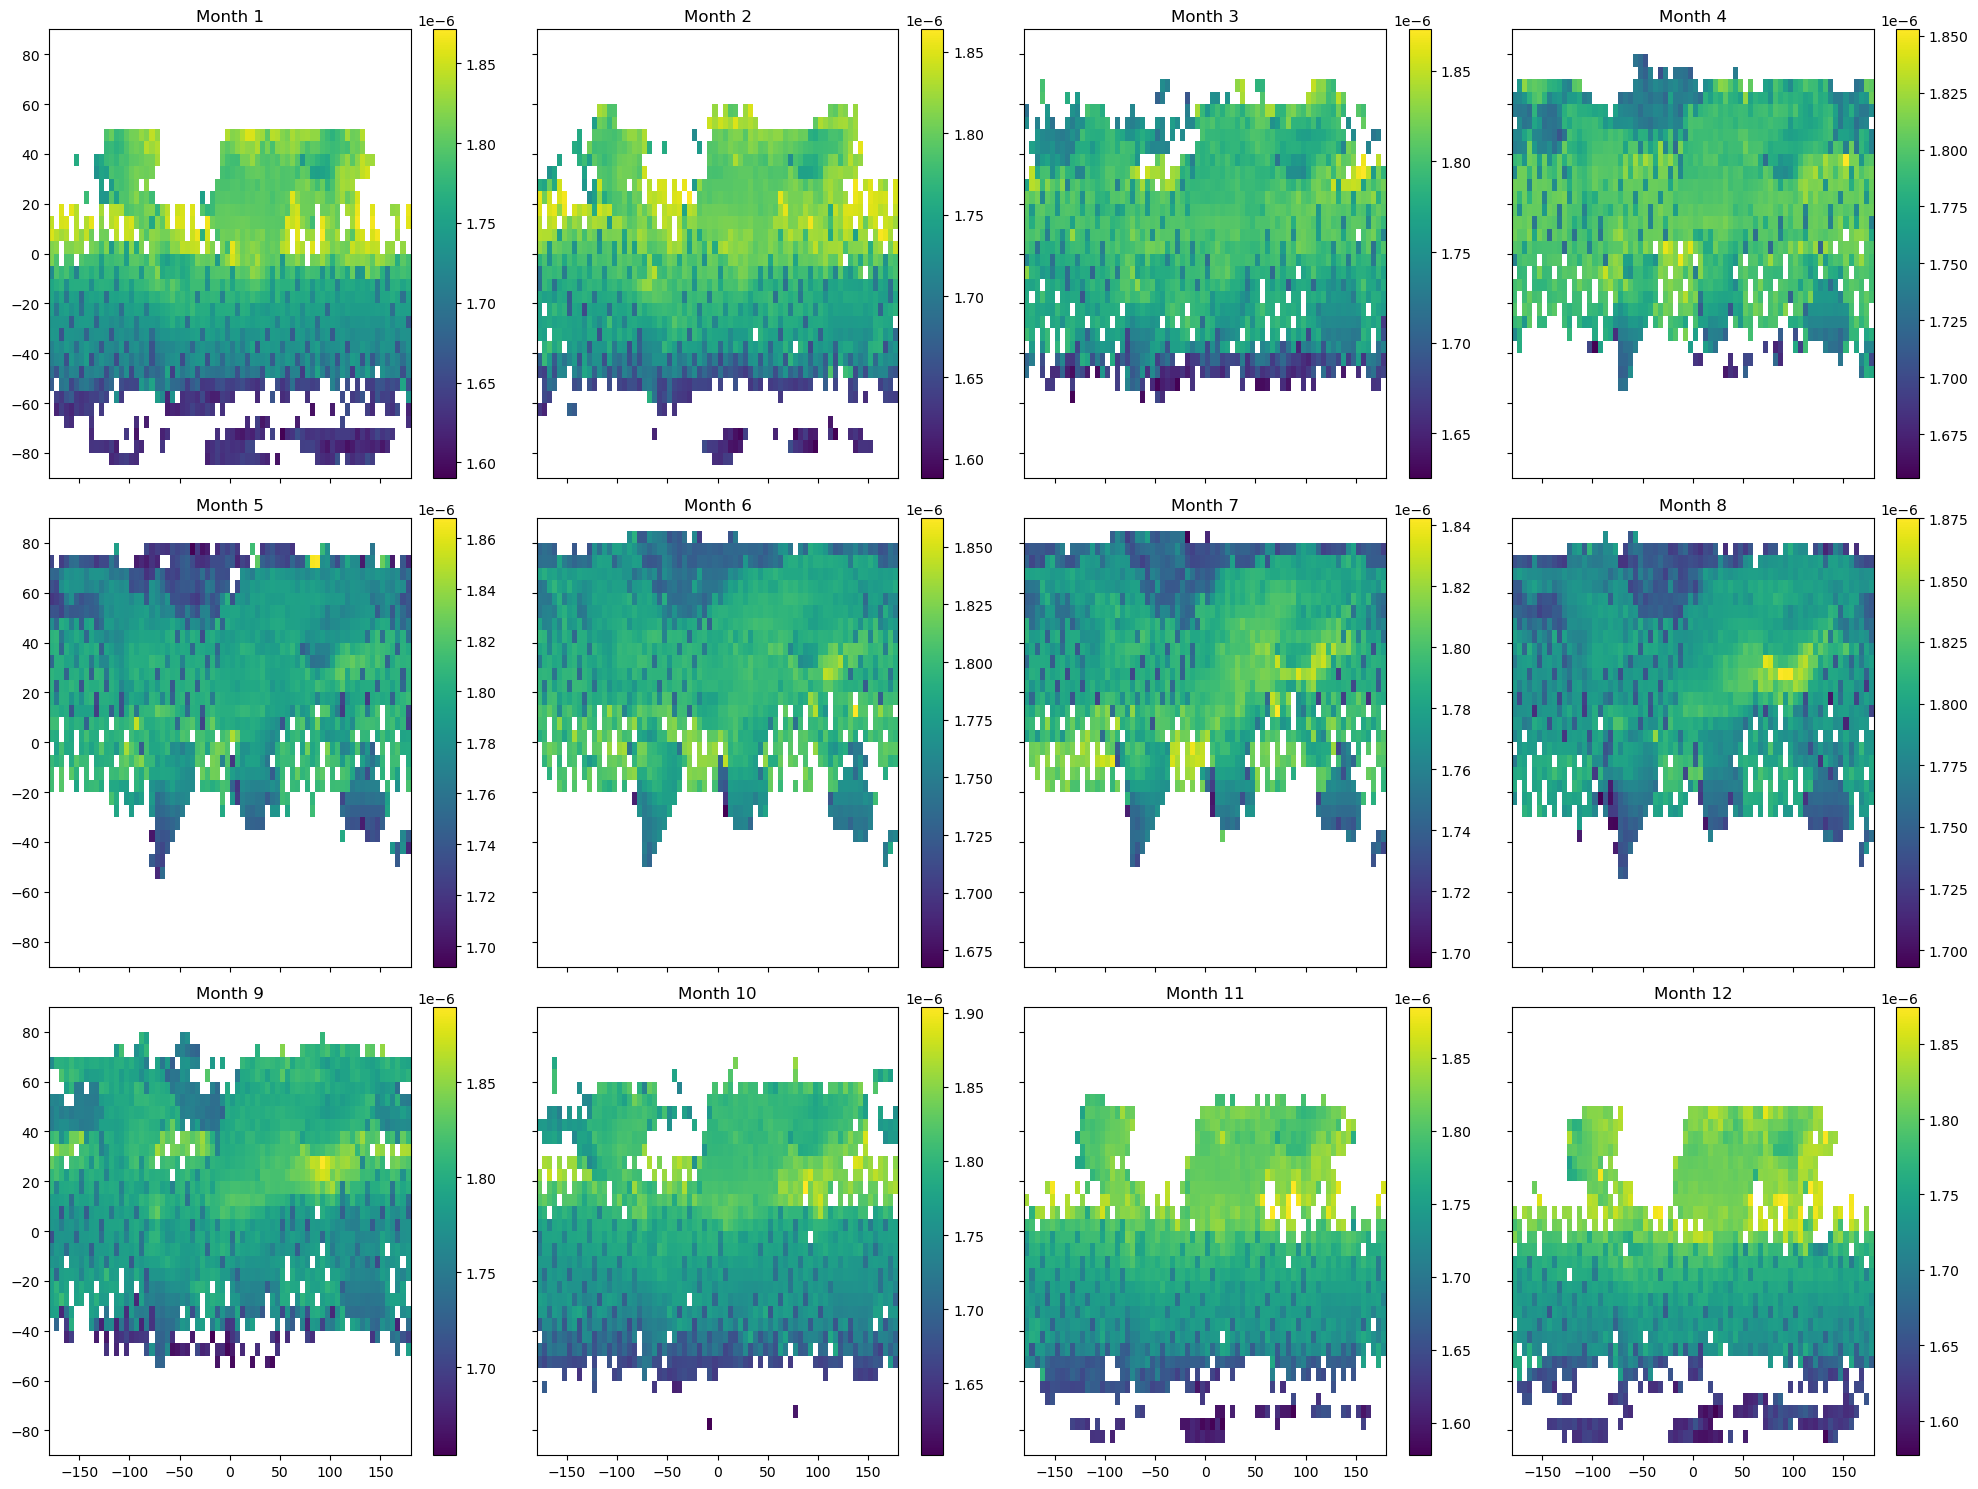

In [6]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15), sharex=True, sharey=True)
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i < len(monthly_mean):
        im = ax.pcolormesh(CH4_DATA.lon, CH4_DATA.lat, monthly_mean[i], shading='auto', cmap='viridis')
        ax.set_title(f'Month {i+1}')
        fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.15, pad=0.05)
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

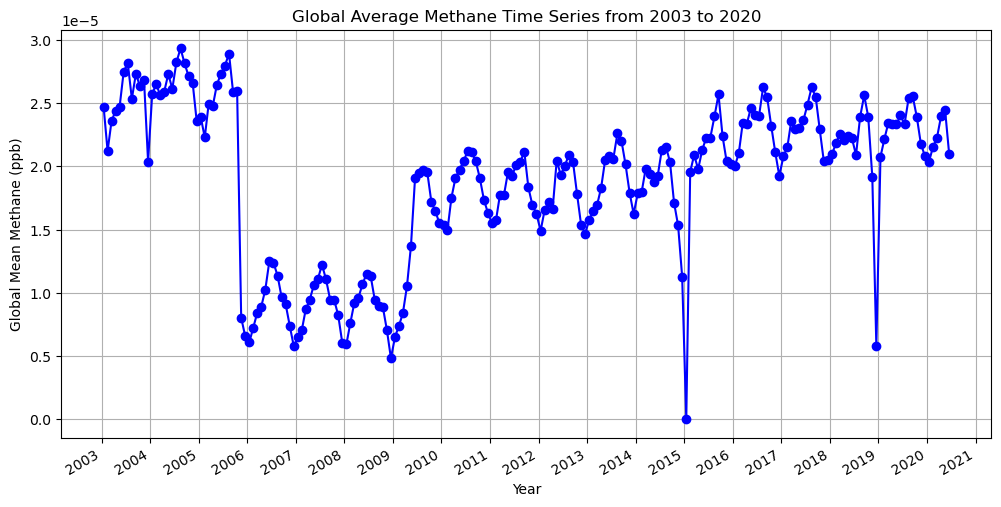

In [7]:
#地球上的区域可以看成一个梯形，根据梯形面积公式由于在地球面积计算时是梯形高不变，面积由上底和下底决定，即他们的平均值也就是梯形中间的宽度决定，也就是中间长度所对应的维度的余弦值决定
lat=CH4_DATA.variables['lat'][:]
time =CH4_DATA.variables['time'][:]
lon =CH4_DATA.variables['lon'][:]
xch4 =CH4_DATA.variables['xch4'][:]
lat_rad = np.deg2rad(lat)#先换成弧度制
weights_lat = np.cos(lat_rad) / np.sum(np.cos(lat_rad))
weights_lat_expanded = np.tile(weights_lat, (len(time), 1, len(lon) // len(weights_lat)))
global_mean_xch4 = np.sum(xch4 * weights_lat_expanded, axis=(1, 2)) / np.sum(weights_lat_expanded, axis=(1, 2))
plt.figure(figsize=(12, 6))
plt.plot_date(time, global_mean_xch4, linestyle='-', color='b')
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gcf().autofmt_xdate()
plt.xlabel('Year')
plt.ylabel('Global Mean Methane (ppb)')
plt.title('Global Average Methane Time Series from 2003 to 2020')
plt.grid(True)
plt.show()

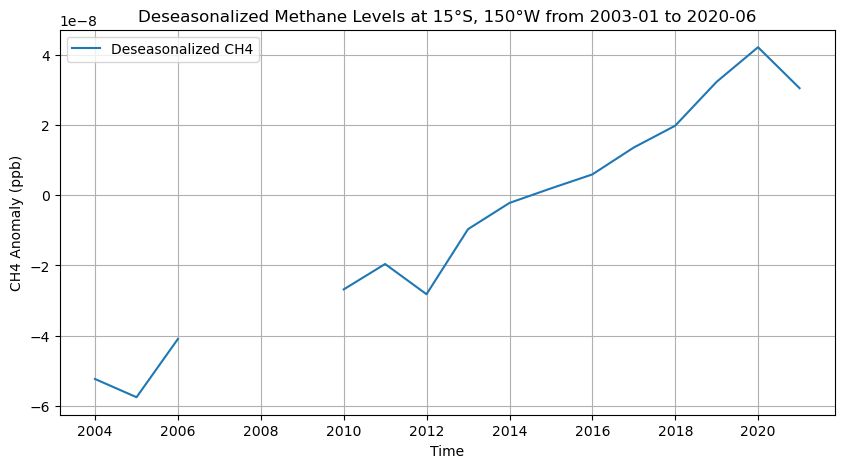

In [19]:
lon_point = 150
lat_point = -15
ch4 = CH4_DATA['xch4'].sel(lat=lat_point, lon=lon_point, method='nearest')
# 计算每个月的甲烷平均值
monthly_mean = ch4.groupby('time.month').mean('time')
# 计算季节性异常值
ch4_anom = ch4.groupby('time.month') - monthly_mean
# 进行重采样
ch4_anom_resampled = ch4_anom.resample(time='1YE').mean()

# 绘制去季节性的时间序列图
plt.figure(figsize=(10, 5))
plt.plot(ch4_anom_resampled.time, ch4_anom_resampled.values, label='Deseasonalized CH4')
plt.xlabel('Time')
plt.ylabel('CH4 Anomaly (ppb)')
plt.title('Deseasonalized Methane Levels at 15°S, 150°W from 2003-01 to 2020-06')
plt.legend()
plt.grid(True)
plt.show()

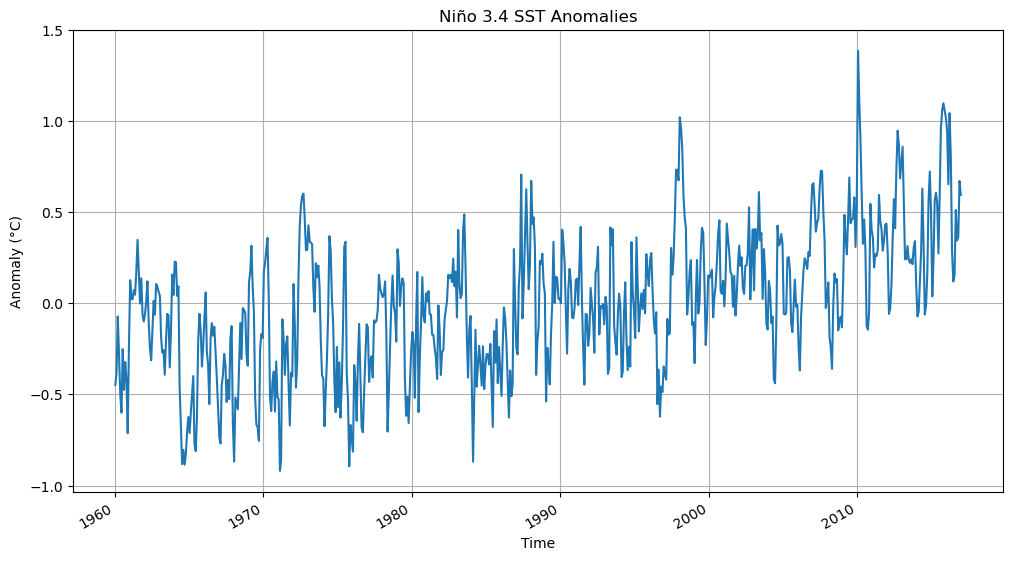

In [41]:
SST=xr.open_dataset("NOAA_NCDC_ERSST_v3b_SST.nc", engine="netcdf4")
SST
ds = xr.open_dataset('NOAA_NCDC_ERSST_v3b_SST.nc')

#选择区域
nino34 = ds.sst.sel(lat=slice(-5, 5), lon=slice(10, 60))

#计算月平均气候学
monthly_climatology = nino34.groupby('time.month').mean('time')

#计算异常值
anomalies = nino34.groupby('time.month') - monthly_climatology

#绘制时间序列图
plt.figure(figsize=(12, 6))
time_series_anomalies = anomalies.mean(dim=['lat', 'lon'])
time_series_anomalies.plot()
plt.title('Niño 3.4 SST Anomalies')
plt.xlabel('Time')
plt.ylabel('Anomaly (°C)')
plt.grid(True)
plt.show()

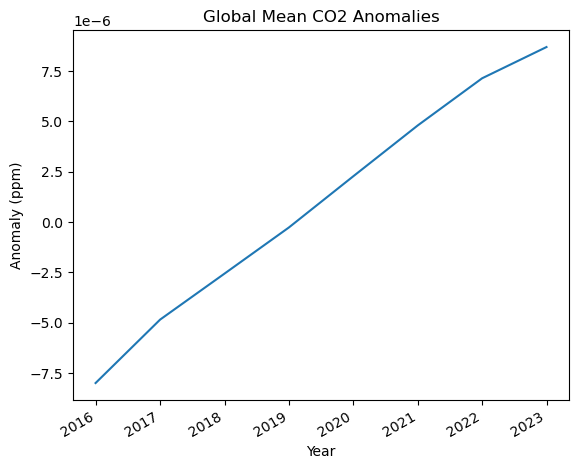

In [96]:
#先对数据进行一下合并
import glob
file_list = glob.glob('D:\\gitkraken\\oco2_GEOS_L3CO2_month_*.nc4')
DATA= xr.open_mfdataset(file_list, combine='by_coords',engine='netcdf4')
DATA
monthly_mean_xco2 = DATA['XCO2'].groupby('time.month').mean('time')
#异常值
anomalies=DATA['XCO2'].groupby('time.month')-monthly_mean_xco2
#重采样按年
yearly_anomalies = anomalies.resample(time='YE').mean()
global_mean_anomalies = yearly_anomalies.mean(dim=['lat', 'lon'])
global_mean_anomalies.plot()
plt.title('Global Mean CO2 Anomalies')
plt.xlabel('Year')
plt.ylabel('Anomaly (ppm)')
plt.show()

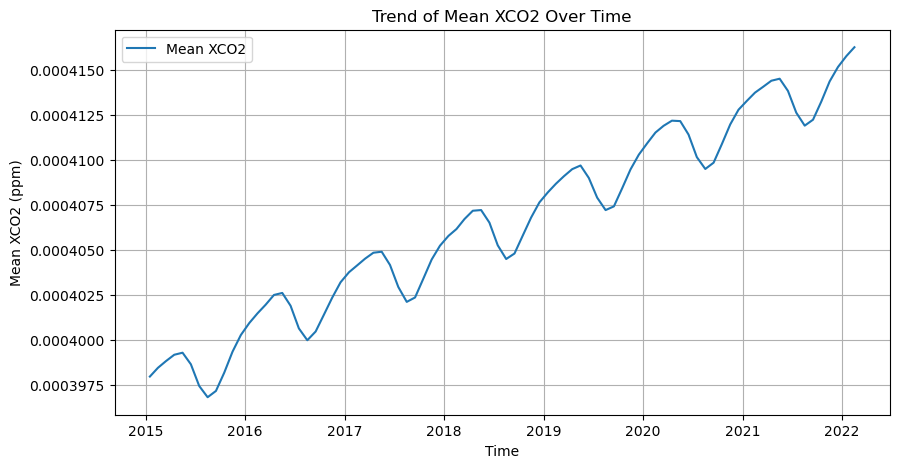

In [145]:
times = pd.to_datetime(DATA['time'].values)
mean_xco2 = DATA['XCO2'].mean('lat').mean('lon')
plt.figure(figsize=(10, 5))
plt.plot(times, mean_xco2, label='Mean XCO2')
plt.xlabel('Time')
plt.ylabel('Mean XCO2 (ppm)')
plt.title('Trend of Mean XCO2 Over Time')
plt.legend()
plt.grid(True)
plt.show()

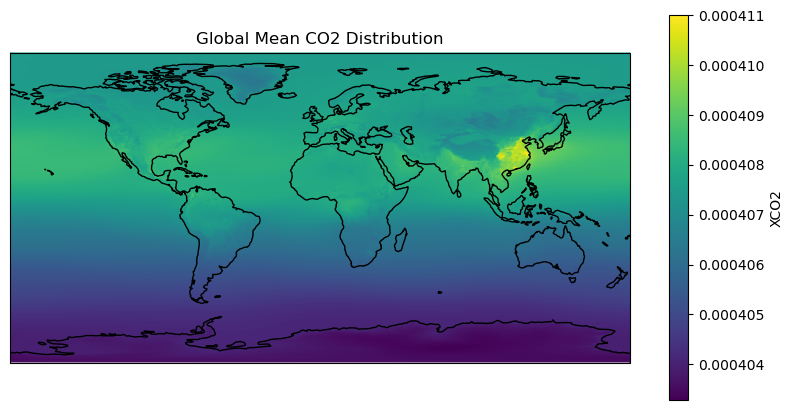

In [102]:
#对数据所包含的所有时间CO2的平均值进行平均，绘制其全球分布图
mean_xco2 = DATA['XCO2'].mean(dim='time')
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_global() 
ax.coastlines() 
mean_xco2.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', add_colorbar=True)
plt.title('Global Mean CO2 Distribution')
plt.show()

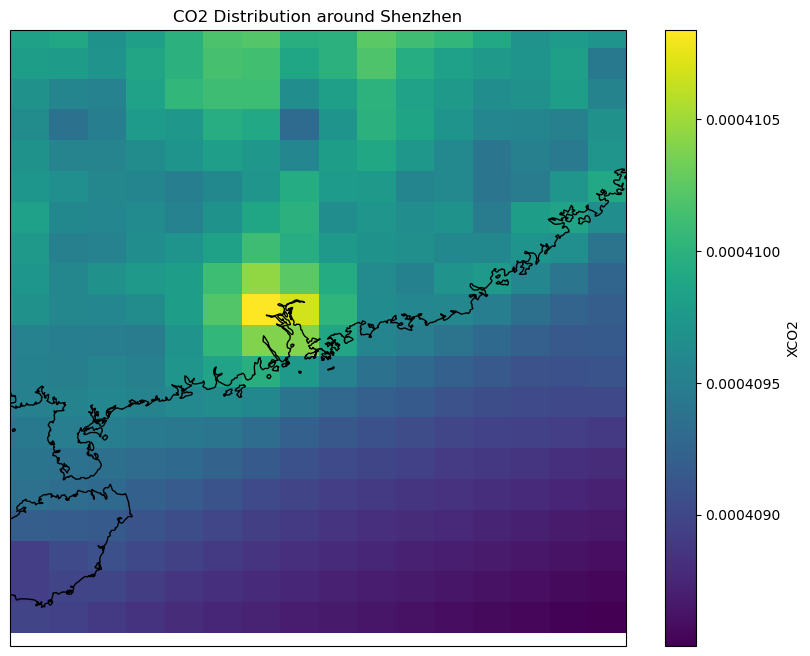

In [116]:
#深圳及其附近地区的CO2分布情况
lat_range = slice(22.54 - 5, 22.54 + 5)  # 纬度范围
lon_range = slice(114.05 - 5, 114.05 + 5)  # 经度范围
shenzhen_xco2 = DATA['XCO2'].sel(lat=lat_range, lon=lon_range)
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon_range.start, lon_range.stop, lat_range.start, lat_range.stop], crs=ccrs.PlateCarree()) 
shenzhen_xco2.mean(dim='time').plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', add_colorbar=True)
ax.set_title('CO2 Distribution around Shenzhen')
ax.coastlines() 

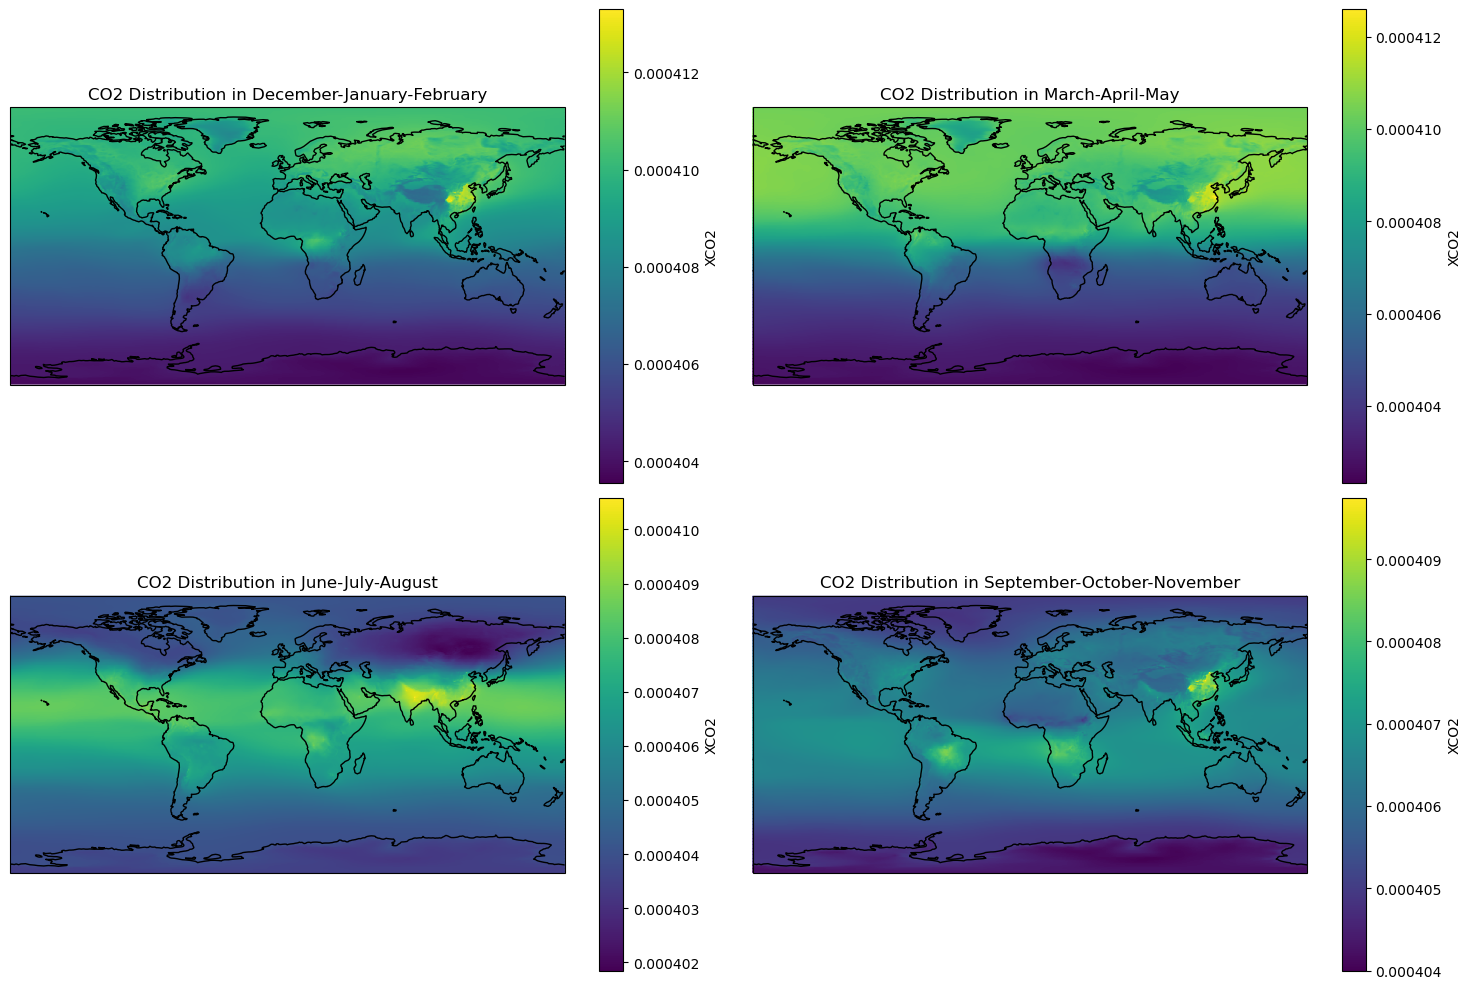

In [141]:
#按四季进行分类画分别每个季节的CO2分布
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()
season_names = ['December-January-February', 'March-April-May', 'June-July-August', 'September-October-November']
for i, ax in enumerate(axes):
    if i == 0:
        season_data = DATA.sel(time=(DATA['time'].dt.month == 12) | (DATA['time'].dt.month == 1) | (DATA['time'].dt.month == 2))
    elif i == 1: 
        season_data = DATA.sel(time=(DATA['time'].dt.month == 3) | (DATA['time'].dt.month == 4) | (DATA['time'].dt.month == 5))
    elif i == 2:
        season_data = DATA.sel(time=(DATA['time'].dt.month == 6) | (DATA['time'].dt.month == 7) | (DATA['time'].dt.month == 8))
    elif i == 3:
        season_data = DATA.sel(time=(DATA['time'].dt.month == 9) | (DATA['time'].dt.month == 10) | (DATA['time'].dt.month == 11))
    seasonal_mean = season_data['XCO2'].mean('time')
    seasonal_mean.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', add_colorbar=True)
    ax.set_title(f'CO2 Distribution in {season_names[i]}')
    ax.coastlines()
    ax.set_global()
plt.tight_layout()
plt.show()

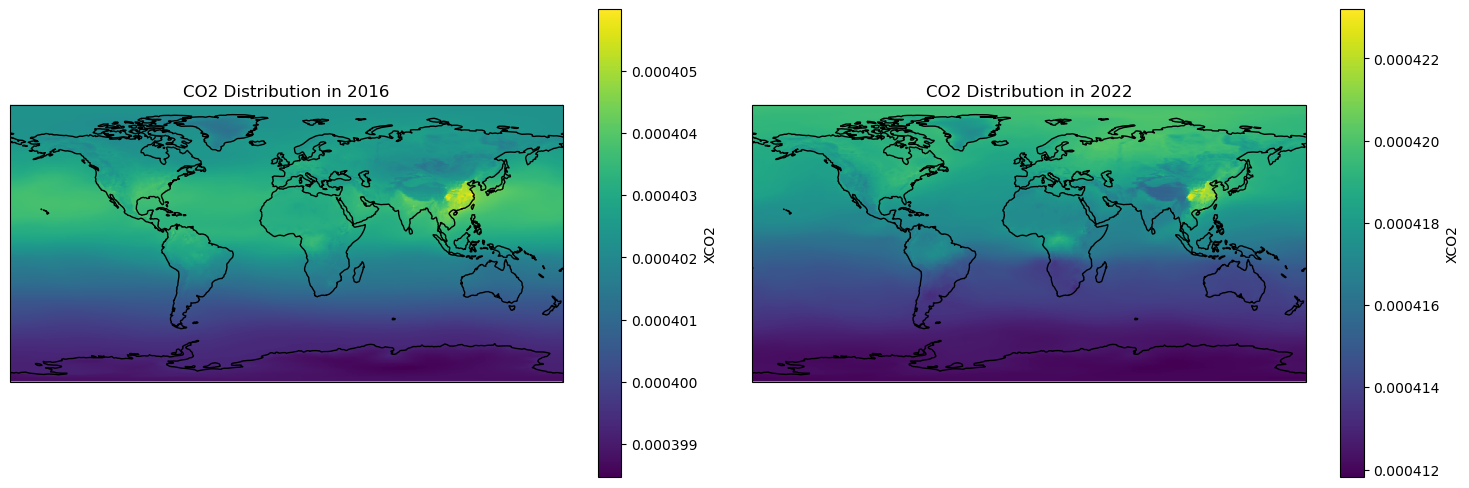

In [143]:
#数据最早一年2016年和最晚一年2022年的CO2进行对比
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()
years = [2016, 2022]
for i, year in enumerate(years):
    year_data = DATA.sel(time=DATA['time'].dt.year == year)
    yearly_mean = year_data['XCO2'].mean('time')
    yearly_mean.plot(ax=axes[i], transform=ccrs.PlateCarree(), cmap='viridis', add_colorbar=True)
    axes[i].set_title(f'CO2 Distribution in {year}')
    axes[i].coastlines()
    axes[i].set_global() 
plt.tight_layout()
plt.show()